In this blog post, we will be revisiting GANs, or general adversarial networks. This isn't the first time we've seen GANs on this blog: we've [implemented GANs in Keras](https://jaketae.github.io/study/gan/), and we have also looked at the [mathematics behind GANs](https://jaketae.github.io/study/gan-math/). Well, this is somewhat of a repeat of what we've done, since all we're doing here is reimplementing GANs using PyTorch, but I still think it's worth a revisit. 

As always, we start by importing the necessary modules in PyTorch, as well as other libraries.

In [13]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

Although we'll be using CPU instead of GPUs, it's always good to have a `device` object set up so that we can utilize GPUs should we run this script or notebook in a different environment.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We're not going to do anything too fancy (and I learned from experience that vanilla GANs are incredibly hard to train and can produce artifact-ridden results). Let's keep in simple this time and try to implement a GAN that generates MNIST images. Below are the configurations we will use for our GAN.

In [14]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 20
batch_size = 64
lr = 0.0002
print_interval = 400
show_interval = num_epochs // 5

We can define a simple transformation that converts images to tensors, then applies a standard normalization procedure for easier training.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])

Next, we create a dataset object and a data loader that batches and shuffles post-transformation images for us.

In [6]:
dataset = datasets.MNIST(root="./data", download=True, transform=transform)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)

You might recall that GANs are composed of two different networks: a discriminator and a generator. The discriminator, also metaphorically referred to as the police, is a classier that tries to determine whether a given data is real or fake, *i.e.* produced by the generator network. The generator, on the other hand, tries to generate images that are as realistic as possible, and so is referred to as the counterfeiter. 

Below is our generator network. Although we could have created DCGANs, or deep convolutional adversarial networks, let's go simple here and just use fully connected layers. 

In [7]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid(),
)

Notice that I've used the `nn.Sequential` PyTorch API instead of using class-based models. In this particular instance, we won't have a complicated forward method, so the sequential API will suffice. 

Next, we create the generator. It is also a sequential model, inside of which are stacks of linear layers with ReLU activations. 

In [8]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh(),
)

Before we jump into training, let's move these networks to the `device` object we've created earlier. 

In [9]:
D = D.to(device)
G = G.to(device)

The interesting part starts here. Notice that we have different optimizers for the discriminator and the generator. This is expected, since we are going to be training two different networks in a different manner.

In [10]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
total_step = len(data_loader)

Before we get into the details of training, here is a simple utility function in which we zero the gradients for both the generator and the discriminator.

In [11]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

We want the discriminator to be able to distinguish real from fake images. Therefore, the discriminator will have a combined loss: the loss that comes from falsely identifying real images as fake, and the loss that comes from confusing fake, generated images as real ones. For the generator, the loss is actually dependent upon the classifier: the loss comes from the classifier correctly identifying generated images as fake. Let's see what this means below. 

Epoch [1/20], Step [400/937], d_loss: 0.9407, g_loss: 2.1113, D(x): 0.75, D(G(z)): 0.29
Epoch [1/20], Step [800/937], d_loss: 0.6839, g_loss: 2.3637, D(x): 0.83, D(G(z)): 0.26
Epoch [2/20], Step [400/937], d_loss: 0.6134, g_loss: 2.2348, D(x): 0.77, D(G(z)): 0.19
Epoch [2/20], Step [800/937], d_loss: 0.7337, g_loss: 2.3552, D(x): 0.82, D(G(z)): 0.27
Epoch [3/20], Step [400/937], d_loss: 0.7162, g_loss: 1.9267, D(x): 0.76, D(G(z)): 0.25
Epoch [3/20], Step [800/937], d_loss: 0.7179, g_loss: 2.4696, D(x): 0.84, D(G(z)): 0.25
Epoch [4/20], Step [400/937], d_loss: 1.0261, g_loss: 1.8885, D(x): 0.65, D(G(z)): 0.26
Epoch [4/20], Step [800/937], d_loss: 0.8428, g_loss: 2.2168, D(x): 0.72, D(G(z)): 0.28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


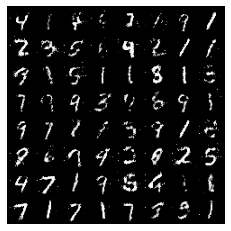

Epoch [5/20], Step [400/937], d_loss: 0.5839, g_loss: 1.8541, D(x): 0.87, D(G(z)): 0.28
Epoch [5/20], Step [800/937], d_loss: 0.7755, g_loss: 2.7654, D(x): 0.64, D(G(z)): 0.08
Epoch [6/20], Step [400/937], d_loss: 0.8418, g_loss: 2.1310, D(x): 0.70, D(G(z)): 0.24
Epoch [6/20], Step [800/937], d_loss: 0.7602, g_loss: 2.4016, D(x): 0.68, D(G(z)): 0.18
Epoch [7/20], Step [400/937], d_loss: 0.6915, g_loss: 1.4121, D(x): 0.75, D(G(z)): 0.22
Epoch [7/20], Step [800/937], d_loss: 0.6491, g_loss: 1.6130, D(x): 0.79, D(G(z)): 0.22
Epoch [8/20], Step [400/937], d_loss: 0.7536, g_loss: 2.3771, D(x): 0.83, D(G(z)): 0.32
Epoch [8/20], Step [800/937], d_loss: 0.8532, g_loss: 1.4595, D(x): 0.71, D(G(z)): 0.28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


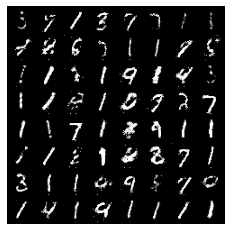

Epoch [9/20], Step [400/937], d_loss: 0.7018, g_loss: 2.2299, D(x): 0.71, D(G(z)): 0.21
Epoch [9/20], Step [800/937], d_loss: 0.7307, g_loss: 1.8550, D(x): 0.78, D(G(z)): 0.29
Epoch [10/20], Step [400/937], d_loss: 0.8762, g_loss: 1.9119, D(x): 0.71, D(G(z)): 0.22
Epoch [10/20], Step [800/937], d_loss: 0.7902, g_loss: 2.0071, D(x): 0.72, D(G(z)): 0.22
Epoch [11/20], Step [400/937], d_loss: 0.6920, g_loss: 1.8780, D(x): 0.81, D(G(z)): 0.26
Epoch [11/20], Step [800/937], d_loss: 0.8210, g_loss: 2.1957, D(x): 0.65, D(G(z)): 0.16
Epoch [12/20], Step [400/937], d_loss: 0.9557, g_loss: 1.4314, D(x): 0.82, D(G(z)): 0.41
Epoch [12/20], Step [800/937], d_loss: 0.7729, g_loss: 2.0351, D(x): 0.68, D(G(z)): 0.18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


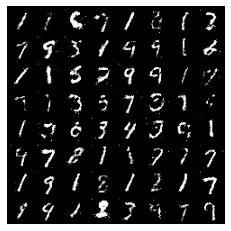

Epoch [13/20], Step [400/937], d_loss: 0.8581, g_loss: 1.8149, D(x): 0.61, D(G(z)): 0.18
Epoch [13/20], Step [800/937], d_loss: 0.9488, g_loss: 1.2383, D(x): 0.76, D(G(z)): 0.39
Epoch [14/20], Step [400/937], d_loss: 0.9165, g_loss: 1.8844, D(x): 0.68, D(G(z)): 0.24
Epoch [14/20], Step [800/937], d_loss: 0.7793, g_loss: 1.6988, D(x): 0.70, D(G(z)): 0.21
Epoch [15/20], Step [400/937], d_loss: 0.8153, g_loss: 1.9821, D(x): 0.81, D(G(z)): 0.32
Epoch [15/20], Step [800/937], d_loss: 0.7998, g_loss: 2.4697, D(x): 0.72, D(G(z)): 0.24
Epoch [16/20], Step [400/937], d_loss: 0.9095, g_loss: 1.3474, D(x): 0.71, D(G(z)): 0.29
Epoch [16/20], Step [800/937], d_loss: 0.8261, g_loss: 2.3547, D(x): 0.71, D(G(z)): 0.27


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


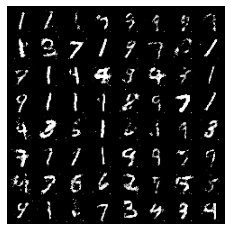

Epoch [17/20], Step [400/937], d_loss: 0.9282, g_loss: 1.6596, D(x): 0.68, D(G(z)): 0.23
Epoch [17/20], Step [800/937], d_loss: 0.9648, g_loss: 1.4077, D(x): 0.84, D(G(z)): 0.45
Epoch [18/20], Step [400/937], d_loss: 1.0193, g_loss: 1.8470, D(x): 0.69, D(G(z)): 0.29
Epoch [18/20], Step [800/937], d_loss: 1.0111, g_loss: 1.4554, D(x): 0.59, D(G(z)): 0.19
Epoch [19/20], Step [400/937], d_loss: 0.8612, g_loss: 2.0555, D(x): 0.70, D(G(z)): 0.25
Epoch [19/20], Step [800/937], d_loss: 0.8627, g_loss: 1.2247, D(x): 0.70, D(G(z)): 0.24
Epoch [20/20], Step [400/937], d_loss: 0.8856, g_loss: 1.6422, D(x): 0.73, D(G(z)): 0.32
Epoch [20/20], Step [800/937], d_loss: 0.6599, g_loss: 1.9306, D(x): 0.79, D(G(z)): 0.24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


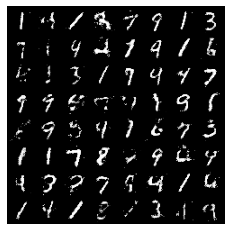

In [23]:
real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # train discriminator
        # real images
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs.mean().item()
        
        # fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs.mean().item()
        
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # train generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        g_loss = criterion(outputs, real_labels)
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], "
                f"Step [{i+1}/{total_step}], "
                f"d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, "
                f"D(x): {real_score:.2f}, D(G(z)): {fake_score:.2f}"
            )
    if (epoch + 1) % show_interval == 0:
        fake_images = fake_images.reshape(batch_size, 1, 28, 28).detach()
        plt.imshow(make_grid(fake_images).permute(1, 2, 0))
        plt.axis("off")
        plt.show()

And we see that the generator was able to produce somewhat confusing hand-written images of digits! Granted, this is far from perfect, and there are images that look somewhat funky. However, there are also somewhat realistic images here and there, and it is impressive that a simple densely connected network was able to achieve this performance. Had we used CNNs, the result might have been even better. Personally, I enjoyed this short implementation experiment because I was able to see just how easy and intuitive it is to use PyTorch. 

I'll come back in the next post with (probably) another PyTorch tutorial. Catch you in the next one!